# 1. Introduction
On January 10, 2016, a Wild Card game between the Seattle Seahawks and Minnesota Vikings came down to a 27 yard field goal attempt by Vikings kicker Blair Walsh with just 25 seconds remaining. Walsh was within field goal range according to the NFL broadcast of the game$^1$. However, Walsh missed the field goal and the Vikings lost. 

The 27 yard miss highlights that "field goal range" is not something well defined. Joe Theismann's "The Complete Idiots Guide to Football" states that most kickers have a range between 45 and 50 yards$^2$. However, within this range 10% of field goals are missed. Between 45 and 49 yards, the leaguewide field goal percentage is just 71%. Kickers also warm up before games and determine their level of comfort attempting field goals from different ranges to determine their field goal range. But there is no tool to precisely define where field goal range is for a kicker.

In this paper, I present a tool that defines field goal range called the Field Goal Range Model(FGRM) by predicting whether field goal attempts will be successful or not given game and weather conditions. To do this I used two models: a K Nearest Neighbors model which classifies field goal attempts as "Successful" or "Not Successful"; and a Decision Tree which communicates the K Nearest Neighbors model's reasoning for classifying a field goal as "Successful" or "Not Successful" to NFL coaches.  
# 2. Data Preparation
The NFL's tracking data is composed of special teams plays from 2018 to 2020. In the data provided, there are 1738 field goal attempts. Anything that isn't listed as a field goal attempt in the NFL's play-level data is removed. Fakes and broken plays such as fumbled snaps are removed from the dataset. Blocked field goals are counted as misses.
Both the K Nearest Neighbors Model and the Decision Tree use the same features. Features were calculated from the NFL's tracking data, play level data, and the weather data provided by Thompson Bliss. The features are:
* Wind along Next Gen Stats Y axis:$w_s * s * sin(d-\phi)$
* Wind along Next Gen Stats X axis:$w_s * s * cos(d-\phi)$
* Precipitation
* Attempting kicker's field goal percentage: $\frac{kicks_{made}}{kicks_{attempted}}$ for each kicker
* Field goal distance: $\begin{cases} 120-absoluteYardlineNumber & playDirection=right \\ absoluteYardlineNumber & playDirection=left\end{cases}$

where $w_s$ is -1 if the play is moving right and 1 if the play is moving left according to the NFL's tracking data, $\phi$ is the stadium azimuth angle, $d$ is the wind direction, and $s$ is the wind speed. The data was split into a training set and testing set. 70% of the field goals were used for training and 30% were used for testing.
## 2.1 Class Imbalance
One thing to note in this dataset of field goals is that approximately 83% of field goals are successful. This is a big issue for FGRM, because if more area of the feature space is taken up by made field goals, the model will adopt a strategy of predicting that every kick will be made. However, this makes our definition of field goal target range the entire field, which is not useful. To account for this class imbalance, the SMOTE algorithm was used. This algorithm randomly selects a real field goal miss, finds its nearest neighbor that also is a field goal miss, and creates a synthetic field goal miss at a random point between them. This was repeated until the dataset consisted of 50% successful field goals and 50% missed field goals.

Concluding this section, here is a visualization of the final dataset in 3 dimensions. Misses are shown with a red "o" and successful attempts are shown with a green "x."

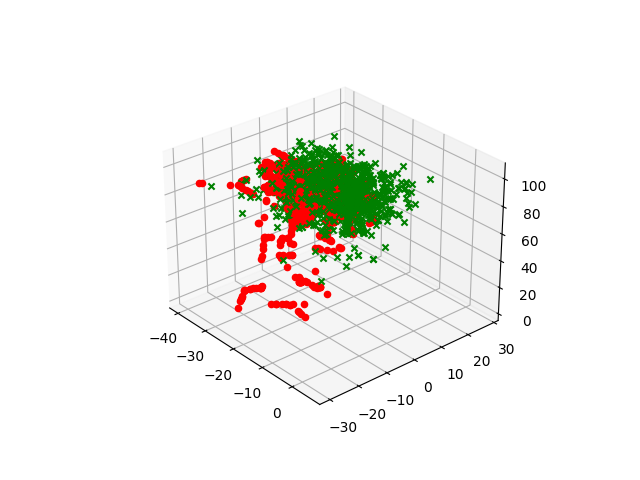
# 3. Field Goal Range Model
## 3.1 K Nearest Neighbors
To define field goal range, we need to know the distance from which each of the NFL's kickers can make field goals. Kickers must be reliable at making kicks from within this distance. The K Nearest Neighbors model accomplishes this task. It uses the features laid out in section 2 to determine if a field goal will be successful at a specified yardage. The model predicts "Kick Attempt Good" or "Kick Attempt No Good." This model is then run on field goals from 17 yards to 66 yards in the current game's weather conditions for a kicker to determine "target zones," that is, zones in which a kicker is in field goal range. 

Conventionally, a kicker's field goal range is described using a target yard line rather than "target zones". However, the leaguewide field goal percentage from beyond 40 yards is just 35%, from beyond 50 yards is 22%, but from beyond 60 yards is 27%. This means that depending on the kicker it may be beneficial to attempt a longer field goal. 

Let's go through the Blair Walsh example above. The kick was attempted outdoors, so weather is a factor for this kick. The stadium's azimuth angle during that game was 90 degrees. There was no precipitation. The wind was blowing west at 12 miles per hour according to the wind measurement taken at the beginning of the game and Weather underground's historical weather data$^1$. Blair Walsh's field goal percentage was 75% that season. Now, the model produces the following plot:

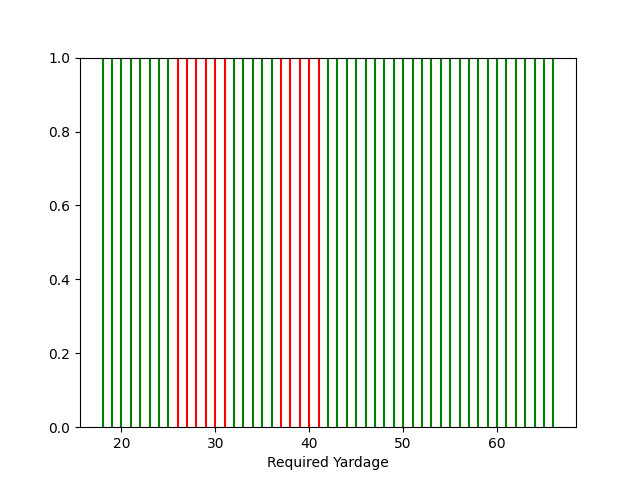

Here, a red line indicates that the field goal is not in range and a green line indicates a field goal is in range. The 27 yard line is considered outside of field goal range here. 


Evaluation metrics and a confusion matrix are shown below. The model does a good job of predicting field goals:

* Accuracy:82.52%
* Precision(Positive Predictive Value):90.24% 
* Recall(True Positive Rate):74.33%
* Negative Predictive Value:76.76%
* Specificity(True Negative Rate):91.35%

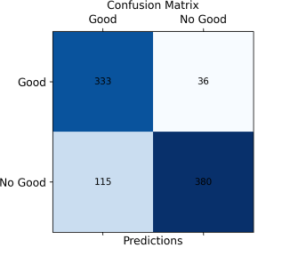
## 3.2 Decision Tree
Despite many teams being analytically inclined now, there are still teams and coaches that go by conventional wisdom or gut instinct. According to ESPN's NFL Analytics survey$^3$, the best way to improve analytics usage is increased buy-in from decision-makers. One AFC staffer said that what holds back analytics is explaining why the model was wrong$^3$. Another staffer said "mistrust, lack of communication, ..., and novelty" all played a role$^3$. The Decision Tree attempts to bridge the divide between analytics staff and coaches. 

The Decision Tree was trained on the K Nearest Neighbors model's inputs and its predictions. It produces a Decision Tree that explains why the K Nearest Neighbors model made a particular decision. This can be used to address scenarios where a coach's wisdom may not match what the K Nearest Neighbors model predicts. Blair Walsh's 27 yard kick is a good example of this. Blair Walsh is within traditional field goal range, yet the K Nearest Neighbors model predicts he will miss the kick. The Decision Tree can provide some insight as to why the K Nearest Neighbors model will predict this. If the result from the K Nearest Neighbors model matches the result from the Decision Tree, we get some insight as to why the K Nearest Neighbors predicted the miss or hit. If the results do not match, then we get a possible reason that either the K Nearest Neighbors model or Decision Tree was wrong and get a reason that the correct model achieved the correct result. 

Below, we see the path that Blair Walsh would have taken. First, Walsh takes the left branch, then the left again, then the left, then the right, landing on the second leaf node from the left. This leaf indicates that the predictions do not match. So, if Blair Walsh made the kick, we would be able to say what the K Nearest Neighbors model was thinking when it predicted the miss - it thought even a short field goal taken by a kicker with a low field goal percentage would miss. 

We can also use the Decision Tree more loosely to gain some insight as to why the Decision Tree was not correct in predicting a successful attempt. Not far from this leaf is a miss leaf(4th from the left). While it wasn't snowing, it's a cold weather game and perhaps that cold weather impacted the kick, particularly the snap and hold. If it did, then Blair Walsh was dangerously close to being outside field goal range. 

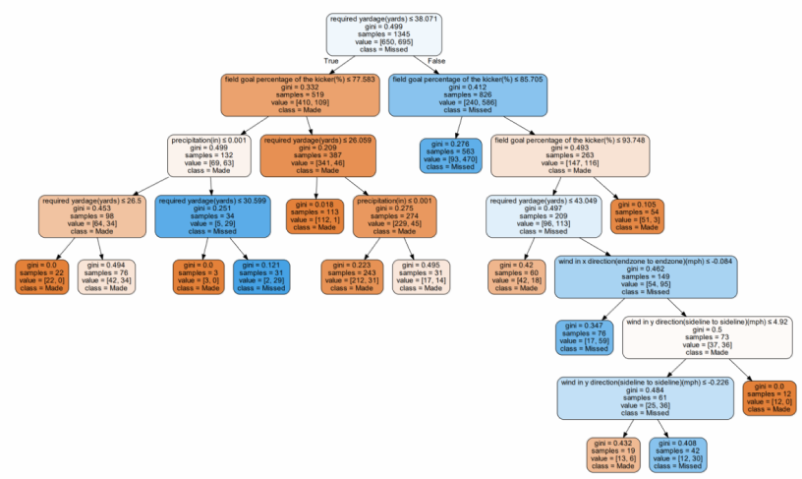

The Decision Tree's accuracy is 83.68%.
# 4. Results

# 4.1 Limitations
One limitation of the FGRM is that at long distances, particularly those over 60 yards, there aren't a lot of field goal attempts. This makes it so that there is a large distance between the field goal being predicted and its nearest neighbor, which causes the model to be inaccurate at these distances. Another drawback is that the FGRM should have an application surrounding it to allow faster predictions. Right now, it expects coaches to look up the weather, their kicker's field goal percentage, and the stadium they are in before predicting. In a real game, this process takes too long. The tool can be made more effective if it automatically looked up the parameters it needs.

# 4.2 Uses
The first way a team may use this model is in game planning. According to the National Oceanic and Atmospheric Administration, a seven day forecast can predict the weather about 80 percent of the time$^4$. This means that on Tuesday, when coaches begin game planning, they can find field goal range. Offensively, they can see their kicker's field goal ranges in the form of target zones. Coaches can use this information to see where pooch kick territory is. Coaches may use the FGRM to decide where they want to go for it on 4th down by looking for field goals that are predicted to fail at short range like the Blair Walsh kick. Defensively, they can also see the opposing kicker's field goal range. Defenses can use this information to predict where field goal range will start and end by figuring out where a kicker can reliably kick a field goal. This may let defenses burn time off the clock by allowing an offense to slowly move a bit closer to the end zone. 

A second way that a team may use the FGRM is during a game. When down by 3 or less points late in a game, usually an offense is looking to get into field goal range. But because field goal range is not well defined, the offense doesn't really know where they are going. Using the model presented, offenses can get a better idea of where field goal range is. This can change decisions to go for it on 4th down, punt to pin the opponent deep in their own end, or try for a long field goal. It can also help teams down late in games understand when they should start running the ball to burn clock time before making a game winning field goal. This information can also be used by defenses to know where they must hold to keep an offense out of field goal range.

Lastly, the league office can also make use of the FGRM. The league can refine the field goal target line shown on TV. According to Joe Theismann's definition of field goal range(45-50 yards) teams make it to field goal range only to miss field goals up to 30% of the time. The FGRM can be used to more accurately convey the chances of making a field goal to fans. 
# 5. References
1. Seahawks vs. Vikings: NFC wild card highlights: NFL. YouTube. (2016, January 10). Retrieved January 2, 2022, from https://youtu.be/N5zFfcPdQN8
2. Theismann, J., Tarcy, B., &amp; Theismann, J. (2001). Field Goals. In The Complete Idiot's Guide to Football. essay, Alpha. 
3. Walder, S. (2021, October 6). 2021 NFL analytics survey: Most and least analytically inclined teams, future GM candidates, more. ESPN. Retrieved January 2, 2022, from https://www.espn.com/nfl/story/_/id/32338821/2021-nfl-analytics-survey-most-least-analytically-inclined-teams-future-gm-candidates-more
4. How reliable are weather forecasts? NOAA SciJinks – All About Weather. (n.d.). Retrieved January 6, 2022, from https://scijinks.gov/forecast-reliability/ 

# 6. Appendix
## 6.1
Code: https://github.com/michaelb18/fgrm

Contact: michaelb18@vt.edu